# pytorch手操线性回归

## 定义

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 生成数据集 y = 2 * w1 + -3.4 * w2 + 4.2

In [214]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0,1,(num_examples,num_inputs)))
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
true_answer = labels.clone()
labels += torch.from_numpy(np.random.normal(0,0.01,size = labels.size()))

print(features[0],labels[0],true_answer[0])
print(-0.4526*2+1.7622*-3.4+4.2)

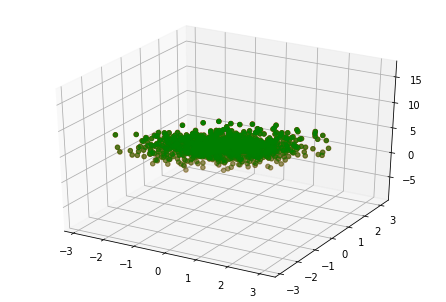

In [216]:
# def use_svg_display():
#     display.set_matplotlib_formats('svg')
#     return
# def set_figsize(figsize=(3.5,2.5)):
#     use_svg_display()
#     plt.rcParams['figure.figsize'] = figsize
#     return
# set_figsize()
from mpl_toolkits.mplot3d import Axes3D


data = np.arange(24).reshape((8,3))
x = features[:,0]
y = features[:,1]
z = labels
z2 = true_answer

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z, color='green')  # 绘制数据点
ax.scatter(x,y,z2, color='red')

plt.show()


# ax = plt.subplot(111, projection='3d')
# ax.scatter(features[:,0],features[:,1],labels,1)
# ax.scatter(features[:,0],features[:,1],true_answer,1)
# plt.show()

In [217]:
# 读取数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size,num_examples)]) # 最后⼀次可能不⾜⼀个batch
    yield features.index_select(0, j), labels.index_select(0,j)
batch_size = 10
for x,y in data_iter(batch_size, features, labels):
    print(x,y)

tensor([[ 0.6869,  1.7346],
        [ 0.6801,  0.1025],
        [ 2.1007,  0.2957],
        [ 1.7528,  0.8675],
        [-0.6811,  0.3922],
        [-1.3617,  2.5566],
        [ 0.0802,  1.2076],
        [-0.3791,  0.1380],
        [-0.0364,  0.7059],
        [ 1.4038, -0.0030]], dtype=torch.float64) tensor([-0.3288,  5.1963,  7.4189,  4.7391,  1.4947, -7.2123,  0.2495,  2.9690,
         1.7309,  7.0035], dtype=torch.float64)


## 初始化w和b，定义矩阵计算，损失函数，优化器

In [218]:
def initwb():
    # 初始化w和b
    w = torch.tensor(np.random.normal(0, 1, (num_inputs, 1)),dtype=torch.double)
    b = torch.zeros(1,dtype=torch.double)

    w.requires_grad_(True)
    b.requires_grad_(True)
    print(w.detach().numpy(),b)
    return w, b
originw, originb = initwb()

[[-1.04621281]
 [ 2.22984395]] tensor([0.], dtype=torch.float64, requires_grad=True)


In [219]:
# 定义回归中的矢量计算表达式
def linreg(X, w, b):
    return torch.mm(X,w)+b
# 平方损失
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size())) ** 2 / 2
# 优化器
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size

## 手写训练

In [220]:
lr = [0.5, 0.3, 0.1, 0.05, 0.03] #学习率
num_epochs = 30
net = linreg
loss = squared_loss

In [221]:
# 计算下初始loss
print("initial loss = %f" % (loss(net(features,originw,originb),labels).mean().item()))

initial loss = 28.571706


[[-1.1613252 ]
 [-0.03551282]] tensor([0.], dtype=torch.float64, requires_grad=True)
[[ 0.24804298]
 [-0.61826587]] tensor([0.], dtype=torch.float64, requires_grad=True)
[[-1.81731801]
 [ 0.33020234]] tensor([0.], dtype=torch.float64, requires_grad=True)
[[-0.38755791]
 [-1.53667684]] tensor([0.], dtype=torch.float64, requires_grad=True)
[[0.85265171]
 [0.27733689]] tensor([0.], dtype=torch.float64, requires_grad=True)


Text(0, 0.5, 'loss')

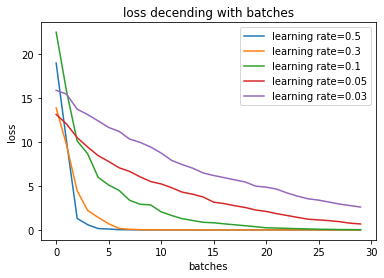

In [222]:
total_loss_y = []

for singleLr in lr:
    w, b = initwb()
    loss_y = []
    for epoch in range(num_epochs):
        # 获得一个batch的数据
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X,w,b),y).sum() #小批量损失

            # 计算总的损失来作图
            total_loss = loss(net(features,w,b),labels).mean().item()
            loss_y.append(total_loss)

            l.backward() #求梯度
            sgd([w,b], singleLr, batch_size) #求得梯度以后 优化参数

            # 梯度清零
            w.grad.data.zero_()
            b.grad.data.zero_()
        train_l = loss(net(features,w,b),labels)
        # print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))
    total_loss_y.append(loss_y)
    
for i, singleLoss in enumerate(total_loss_y):
    plt.plot(singleLoss, label = 'learning rate='+str(lr[i]))

plt.title('loss decending with batches')
plt.legend(loc=1)
plt.xlabel('batches')
plt.ylabel('loss')

In [44]:
print(true_w, ' <---> ', w.detach().view((2)).numpy())
print(true_b, ' <---> ', b.detach().numpy().item())

[2, -3.4]  <--->  [ 1.99897825 -3.40069182]
4.2  <--->  4.199371376820204


## 使用pyTorch进行模型编辑和训练

#### 生成数据集

In [264]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0,1,(num_examples,num_inputs)),dtype = torch.float32)
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
true_answer = labels.clone()
labels += torch.tensor(np.random.normal(0,0.01, size = labels.size()),dtype = torch.float32)

print(features[0],labels[0],true_answer[0])
print(-0.4526*2+1.7622*-3.4+4.2)


import torch.utils.data as Data

batch_size = 10
# 读取数据
dataset = Data.TensorDataset(features, labels)
# 生成随机迭代器
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

tensor([1.5021, 0.5392]) tensor(5.3665) tensor(5.3710)
-2.6966799999999997


In [265]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0.1508,  0.3366],
        [ 1.1101,  0.7339],
        [-1.6094,  0.7896],
        [-0.3679, -0.7506],
        [ 0.7197, -0.8945],
        [-0.9194, -0.5471],
        [ 0.3052, -1.2302],
        [ 0.4842, -1.6763],
        [ 0.6536, -1.1915],
        [-0.8464, -0.0218]]) tensor([ 3.3616,  3.9143, -1.7176,  6.0213,  8.6872,  4.2177,  8.9919, 10.8624,
         9.5612,  2.5843])


#### 定义模型

In [266]:
import torch.nn as nn # neural networks

# nn.Module 可以表示层 也可以表示多层网络
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        
        # forward
        def forward(self, x):
            y = self.linear(x)
            return y
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


另外使用sequential的写法

In [267]:
# 1
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
)

# 2
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs,1))
# 可以继续添加

# 3
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
#     ('linear', nn.Linear(num_inputs,1))
#     # ...
# ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [268]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6749, -0.2427]], requires_grad=True)
Parameter containing:
tensor([0.5657], requires_grad=True)


**注意: torch.nn 仅支持输入一个batch的样本,不支持单个样本输入,如果只有单个样本，可使⽤ input.unsqueeze(0) 来添加⼀维。**

#### 初始化参数，定义函数

In [269]:
from torch.nn import init
import torch.optim as optim

init.normal_(net[0].weight, mean = 0, std = .01)
init.constant_(net[0].bias, val=0) # 也可以 net[0].bias.data.fill_(0)

# MSELoss
loss = nn.MSELoss()

#optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [270]:
for param_group in optimizer.param_groups:
    print(param_group)
    # 直接调整lr来调整学习率

{'params': [Parameter containing:
tensor([[ 0.0147, -0.0147]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)], 'lr': 0.03, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}


#### 开始训练

In [279]:
num_epochs = 3
for epoch in range(1, num_epochs+1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000087
epoch 2, loss: 0.000135
epoch 3, loss: 0.000068


In [285]:
dense = net[0]
estiw=0
estib=0
for param in dense.weight:
    estiw = param.detach().numpy()
for param in dense.bias:
    estib = param.detach().numpy().item()
print(true_w, ' <--> ',estiw)
print(true_b, ' <--> ',estib)

[2, -3.4]  <-->  [ 1.9996343 -3.4013832]
4.2  <-->  4.200665473937988




# SoftMax回归

## 使用pyTorch分类Fashion-MNIST(2)

#### 导入包，获取数据集

In [48]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

In [49]:
mnist_train = torchvision.datasets.FashionMNIST('/Users/criticlove/Documents/study/deeplearning/Datasets/FashionMNIST', 
                                                train = True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST('/Users/criticlove/Documents/study/deeplearning/Datasets/FashionMNIST', 
                                                train = False, download=True, transform=transforms.ToTensor())

In [50]:
print(type(mnist_train))
print(len(mnist_train),len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


查看单个特征的形状和标签

In [51]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


In [52]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 
                'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12,12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28,28)).numpy(), cmap='gray')
        f.set_title(lbl)
        f.axes.get_yaxis().set_visible(False)
        f.axes.get_xaxis().set_visible(False)
    plt.show()
    return

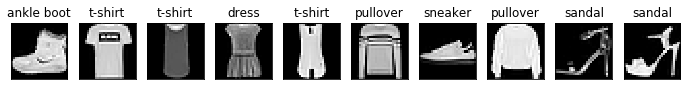

In [53]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

读取小批量数据

In [54]:
import torch.utils.data as Data

batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = Data.DataLoader(mnist_train, batch_size,shuffle=True, num_workers=num_workers)
test_iter = Data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=num_workers)

读取一遍数据所需时间

In [55]:
start = time.time()
for X, y in train_iter:
    continue

print('%.2f sec' % (time.time() - start))

4.54 sec


## 手写Softmax分类

#### 初始化参数

In [77]:
num_inputs = 28*28
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

矩阵运算展示

In [31]:
X = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))

tensor([[5, 7, 9]])


In [57]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim = 1,keepdim=True)
    return X_exp/partition #广播

def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)
X = torch.rand((3,3))
print(softmax(X).sum(dim=1,keepdim=True))

tensor([[1.0000],
        [1.0000],
        [1.0000]])


定义损失函数

交叉熵损失：

H(y,y_hat) = - sumof1-q(y * log(y_hat))

l = 1/n(sumof1-n(H))

In [70]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

# 优化器
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size

print(evaluate_accuracy(test_iter, net))

0.0963


#### 开始构建模型

In [80]:
num_epochs = 5
lr = 0.1

def train_ch3(net, train_iter, test_iter, 
              loss, num_epochs, batch_size, 
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            # 计算梯度
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            train_loss_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1) == y).float().sum().item()
            n+=y.shape[0]
            
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch+1, train_loss_sum/n, train_acc_sum/n, test_acc))
    return

#### 开始训练

In [81]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W,b], lr)

epoch 1, loss 0.7850, train acc 0.752, test acc 0.781
epoch 2, loss 0.5720, train acc 0.811, test acc 0.812
epoch 3, loss 0.5269, train acc 0.824, test acc 0.821
epoch 4, loss 0.5011, train acc 0.831, test acc 0.824
epoch 5, loss 0.4853, train acc 0.837, test acc 0.828


#### 数据展示

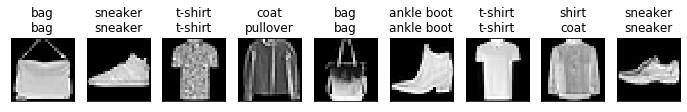

In [83]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true+'\n'+pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9],titles[0:9])

## 用pyTorch模型来Softmax

#### 跟前面一样

In [43]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import funcs as d2l
from matplotlib import pyplot as plt


batch_size = 256
num_inputs = 28*28
num_outputs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### 定义网络

In [44]:
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x shape:(batch, 1, 28, 28)
        y = self.linear(x.view((x.shape[0], -1)))
        return y
    
net = LinearNet(num_inputs, num_outputs)

更方便的定义模型

In [79]:
from collections import OrderedDict
net = nn.Sequential(
    OrderedDict([
    ('flatten', nn.Flatten()),
    ('linear', nn.Linear(num_inputs, num_outputs))])
    )

print(net)

init.normal_(net.linear.weight, mean=0.3, std=0.1)
init.constant_(net.linear.bias, val=0)
loss = nn.CrossEntropyLoss()

Sequential(
  (flatten): Flatten()
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [80]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

In [16]:
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, 
                  loss, num_epochs, batch_size, 
                  None, None, optimizer)

epoch 1, loss 0.0032, train acc 0.727, test acc 0.783
epoch 2, loss 0.0023, train acc 0.806, test acc 0.795
epoch 3, loss 0.0021, train acc 0.819, test acc 0.793
epoch 4, loss 0.0020, train acc 0.828, test acc 0.799
epoch 5, loss 0.0019, train acc 0.833, test acc 0.822


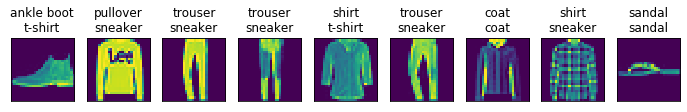

In [81]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true+'\n'+pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9],titles[0:9])

In [84]:
def train_ch3(net, train_iter, test_iter, 
              loss, num_epochs, batch_size, 
              params=None, lr=None, optimizer=None):
    nn = 0
    total_epochs = []
    total_loss = []
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            # 计算梯度
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            train_loss_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1) == y).float().sum().item()
            n+=y.shape[0]
            nn+=1
            
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        total_epochs.append(epoch+1)
        total_loss.append(train_loss_sum/nn)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch+1, train_loss_sum/nn, train_acc_sum/n, test_acc))
    return total_epochs, total_loss

In [85]:
batch_sizes = [32, 128, 1024, 10000, 60000]
total_train_loss = []
total_epoch = []
num_epochs = 10
for i, batch_size in enumerate(batch_sizes):
    # initialize parameters
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    init.normal_(net.linear.weight, mean=0.3, std=0.1)
    init.constant_(net.linear.bias, val=0)
    
    # train get train loss
    sub_epoch, sub_loss = train_ch3(net, train_iter, test_iter, 
                  loss, num_epochs, batch_size, 
                  None, None, optimizer)
    total_train_loss.append(sub_loss)
    total_epoch.append(sub_epoch)

epoch 1, loss 0.6068, train acc 0.794, test acc 0.821
epoch 2, loss 0.2450, train acc 0.832, test acc 0.831
epoch 3, loss 0.1562, train acc 0.838, test acc 0.835
epoch 4, loss 0.1138, train acc 0.844, test acc 0.834
epoch 5, loss 0.0893, train acc 0.847, test acc 0.834
epoch 6, loss 0.0733, train acc 0.848, test acc 0.839
epoch 7, loss 0.0623, train acc 0.850, test acc 0.839
epoch 8, loss 0.0541, train acc 0.850, test acc 0.841
epoch 9, loss 0.0479, train acc 0.851, test acc 0.838
epoch 10, loss 0.0428, train acc 0.851, test acc 0.834
epoch 1, loss 0.7202, train acc 0.754, test acc 0.805
epoch 2, loss 0.2650, train acc 0.819, test acc 0.795
epoch 3, loss 0.1649, train acc 0.831, test acc 0.816
epoch 4, loss 0.1188, train acc 0.838, test acc 0.807
epoch 5, loss 0.0925, train acc 0.841, test acc 0.832
epoch 6, loss 0.0755, train acc 0.845, test acc 0.837
epoch 7, loss 0.0636, train acc 0.846, test acc 0.836
epoch 8, loss 0.0549, train acc 0.850, test acc 0.835
epoch 9, loss 0.0483, train

Text(0, 0.5, 'loss')

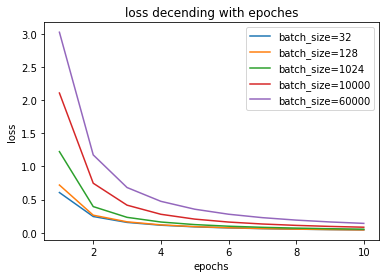

In [90]:
for i,(epoch, loss_) in enumerate(zip(total_epoch, total_train_loss)):
    plt.plot(epoch, loss_, label = 'batch_size='+str(batch_sizes[i]))
plt.title('loss decending with epoches')
plt.legend(loc=1)
plt.xlabel('epochs')
plt.ylabel('loss')